In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.svm import SVC
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report
import time

In [2]:
opt_params = pd.DataFrame(pd.read_csv('opt_params.csv', index_col=0))

In [3]:
opt_params

,short,long,slow,fast,period,high,low,oversold,overbought,n,m
chaikin_oscillator,6.0,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
macd_strategy,NaN,NaN,3.0,47.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
williams_r,NaN,NaN,NaN,NaN,4.0,-62.0,-32.0,NaN,NaN,NaN,NaN
mfi,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
stockhastic_oscillator,NaN,NaN,NaN,NaN,5.0,NaN,NaN,31.0,75.0,NaN,NaN
keltner_channels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,1.0
cci,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
opt_params.loc['chaikin_oscillator','short']

6.0

In [5]:
df = pd.read_csv('data/BTC.csv')
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.date
df

,timestamp,open,high,low,close,volume
0,2018-01-01,13850.49,13921.53,12877.67,13444.88,1.057522e+09
1,2018-01-02,13444.88,15306.13,12934.16,14754.13,1.956783e+09
2,2018-01-03,14754.09,15435.01,14579.71,15156.62,1.604207e+09
3,2018-01-04,15156.49,15408.66,14244.67,15180.08,1.656715e+09
4,2018-01-05,15180.08,17126.95,14832.36,16954.78,2.283989e+09
...,...,...,...,...,...,...
1915,2023-03-31,28037.46,28650.47,27541.23,28477.29,1.436740e+09
1916,2023-04-01,28477.29,28810.95,28265.42,28465.30,5.632994e+08
1917,2023-04-02,28465.30,28538.36,27880.95,28186.76,5.925811e+08
1918,2023-04-03,28186.76,28494.64,27290.26,27810.08,1.467725e+09


In [6]:
result_df = pd.DataFrame(index=df.index)
result_df['timestamp'] = df['timestamp']
result_df['open'] = df['open']
result_df['high'] = df['high']
result_df['low'] = df['low']
result_df['close'] = df['close']
result_df['volume'] = df['volume']
result_df.head(3)

,timestamp,open,high,low,close,volume
0,2018-01-01,13850.49,13921.53,12877.67,13444.88,1.057522e+09
1,2018-01-02,13444.88,15306.13,12934.16,14754.13,1.956783e+09
2,2018-01-03,14754.09,15435.01,14579.71,15156.62,1.604207e+09


In [7]:
def chaikin_oscillator(df: pd.DataFrame, result_df: pd.DataFrame, short:int, long:int) -> pd.DataFrame:
    # calculate the Chaikin Oscillator
    adl = ((2 * df['close'] - df['high'] - df['low']) / (df['high'] - df['low'])) * df['volume']
    adl_3_ema = adl.ewm(span=short).mean()
    adl_10_ema = adl.ewm(span=long).mean()
    chaikin_oscillator = adl_3_ema - adl_10_ema
    # Trading signals -> 1 indicates Buy, 0 indicates Hold and -1 indicates Sell
    result_df['Chaikin_oscillator'] = np.where(chaikin_oscillator > 0, 1, 0)
    result_df['Chaikin_oscillator'] = np.where(chaikin_oscillator < 0, -1, result_df['Chaikin_oscillator'])
    return result_df
result_df = chaikin_oscillator(df, result_df, short = opt_params.loc['chaikin_oscillator','short'], long = opt_params.loc['chaikin_oscillator','long'])
print(len(result_df.index))
result_df.Chaikin_oscillator.value_counts()

1920


 1    978
-1    941
 0      1
Name: Chaikin_oscillator, dtype: int64

In [8]:
def macd_strategy(data,result_df, fast_period=12, slow_period=26, signal_period=9):
    ema_fast = df['close'].ewm(span=fast_period, adjust=False).mean()
    ema_slow = df['close'].ewm(span=slow_period, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    # Generate trading signals based on the MACD and signal line
    result_df['MACD'] = 0
    result_df['MACD'] = np.where(macd > signal, 1, 0)
    result_df['MACD'] = np.where(macd < signal, -1, result_df['MACD'])
    return result_df
result_df = macd_strategy(df, result_df, 
                          fast_period=opt_params.loc['macd_strategy','fast'], 
                          slow_period=opt_params.loc['macd_strategy','slow'], 
                          signal_period=opt_params.loc['macd_strategy','period'])
print(len(result_df.index))
result_df.MACD.value_counts()

1920


-1    1031
 1     888
 0       1
Name: MACD, dtype: int64

In [9]:
int(opt_params.loc['williams_r','low'])

-32

In [10]:
def williams_r(df: pd.DataFrame,result_df, period: int, high:int, low: int) -> pd.DataFrame:
    highest_high = df['high'].rolling(window = period).max()
    lowest_low = df['low'].rolling(window = period).min()
    wpr = -100 * (highest_high - df['close']) / (highest_high - lowest_low)

    result_df['williams_percentage'] = np.where(wpr < high, 1, 0)
    result_df['williams_percentage'] = np.where(wpr > low, -1, result_df['williams_percentage'])
    
    return result_df
result_df = williams_r(df,result_df, 
                       high = int(opt_params.loc['williams_r','high']), 
                       low = int(opt_params.loc['williams_r','low']), 
                       period= int(opt_params.loc['williams_r','period']))
print(len(result_df.index))
result_df.williams_percentage.value_counts()

1920


-1    740
 1    684
 0    496
Name: williams_percentage, dtype: int64

In [11]:
def money_flow_index(df: pd.DataFrame, result_df: pd.DataFrame, n: int) -> pd.DataFrame:
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    raw_money_flow = typical_price * df['volume']
    positive_flow = np.where(typical_price > typical_price.shift(1), raw_money_flow, 0)
    negative_flow = np.where(typical_price < typical_price.shift(1), raw_money_flow, 0)
    positive_mf = pd.Series(positive_flow).rolling(n).sum()
    negative_mf = pd.Series(negative_flow).rolling(n).sum()
    mfi = 100 - (100 / (1 + (positive_mf / negative_mf)))
    mfi_signal = pd.Series(mfi).rolling(3).mean()
    result_df['MFI'] = np.where(mfi > mfi_signal, 1, 0)
    result_df['MFI'] = np.where(mfi < mfi_signal, -1, result_df['MFI'])
    return result_df

result_df = money_flow_index(df,result_df, n = int(opt_params.loc['mfi','period']))
print(len(result_df.index))
result_df.MFI.value_counts()

1920


 1    999
-1    885
 0     36
Name: MFI, dtype: int64

In [12]:
def stochastic_oscillator_strategy(df, result_df, period:int, oversold:int, overbought:int):
    highs = df['high']
    lows = df['low']
    closes = df['close']

    # Calculate the stochastic oscillator
    stochastic_oscillator = 100 * ((closes - lows.rolling(period).min()) / (highs.rolling(period).max() - lows.rolling(period).min()))
    result_df['Stochastic_oscillator'] = 0
    result_df['Stochastic_oscillator'] = np.where(stochastic_oscillator < oversold, 1, 0)
    result_df['Stochastic_oscillator'] = np.where(stochastic_oscillator > overbought, -1, result_df['Stochastic_oscillator'])

    return result_df
result_df = stochastic_oscillator_strategy(df, result_df, period= int(opt_params.loc['stockhastic_oscillator','period']), 
                                           oversold= int(opt_params.loc['stockhastic_oscillator','oversold']), 
                                           overbought= int(opt_params.loc['stockhastic_oscillator','overbought']))
print(len(result_df.index))
result_df.Stochastic_oscillator.value_counts()

1920


 0    776
-1    584
 1    560
Name: Stochastic_oscillator, dtype: int64

In [13]:
def keltner_channels(df: pd.DataFrame, result_df: pd.DataFrame, n: int = 10, m: int = 1) -> pd.DataFrame:
    middle_line = df['close'].ewm(span=n).mean()
    tr1 = df['high'] - df['low']
    tr2 = abs(df['high'] - df['close'].shift())
    tr3 = abs(df['low'] - df['close'].shift())
    true_range = pd.DataFrame({'tr1': tr1, 'tr2': tr2, 'tr3': tr3}).max(axis=1)
    upper_band = middle_line + m * true_range.ewm(span=n).mean()
    lower_band = middle_line - m * true_range.ewm(span=n).mean()
    # Generate signals
    result_df['Keltner_channels'] = 0
    result_df.loc[(df['close'] > upper_band), 'Keltner_channels'] = -1  # Sell signal
    result_df.loc[(df['close'] < lower_band), 'Keltner_channels'] = 1  # Buy signal
    return result_df
result_df = keltner_channels(df, result_df, n = opt_params.loc['keltner_channels','n'], m = opt_params.loc['keltner_channels','m'])

In [14]:
def commodity_channel_index(df: pd.DataFrame, result_df: pd.DataFrame, period: int = 20) -> pd.DataFrame:
    typical_price = (df['low'] + df['high'] + df['close']) / 3
    moving_average = typical_price.rolling(window=period).mean()
    mean_deviation = typical_price.rolling(window=period).apply(lambda x: np.fabs(x - x.mean()).mean())
    cci = (typical_price - moving_average) / (0.015 * mean_deviation)

    result_df['CCI'] = np.where(cci > 100, 1, 0)
    result_df['CCI'] = np.where(cci < -100, -1, result_df['CCI'])
    return result_df
result_df = commodity_channel_index(df, result_df, period = int(opt_params.loc['cci','period']))

In [15]:
result_df

,timestamp,open,high,low,close,volume,Chaikin_oscillator,MACD,williams_percentage,MFI,Stochastic_oscillator,Keltner_channels,CCI
0,2018-01-01,13850.49,13921.53,12877.67,13444.88,1.057522e+09,0,0,0,0,0,0,0
1,2018-01-02,13444.88,15306.13,12934.16,14754.13,1.956783e+09,1,-1,0,0,0,0,0
2,2018-01-03,14754.09,15435.01,14579.71,15156.62,1.604207e+09,1,-1,0,0,0,0,0
3,2018-01-04,15156.49,15408.66,14244.67,15180.08,1.656715e+09,1,-1,-1,0,0,0,0
4,2018-01-05,15180.08,17126.95,14832.36,16954.78,2.283989e+09,1,-1,-1,0,-1,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,2023-03-31,28037.46,28650.47,27541.23,28477.29,1.436740e+09,1,-1,-1,-1,0,0,0
1916,2023-04-01,28477.29,28810.95,28265.42,28465.30,5.632994e+08,1,-1,0,1,0,0,1
1917,2023-04-02,28465.30,28538.36,27880.95,28186.76,5.925811e+08,-1,1,0,1,0,0,0
1918,2023-04-03,28186.76,28494.64,27290.26,27810.08,1.467725e+09,-1,1,1,-1,1,0,0


In [16]:
df = result_df

In [17]:
df['pct_change'] = df['close'].pct_change(periods=3).mul(100)
df['target'] = 0
df.loc[df['pct_change'] > 2, 'target'] = 1
df.loc[df['pct_change'] < -2, 'target'] = -1
df['target'].value_counts()

 1    671
 0    643
-1    606
Name: target, dtype: int64

In [18]:
df.drop(['pct_change'], axis = 1, inplace = True)

In [19]:
df.fillna(0, inplace=True)

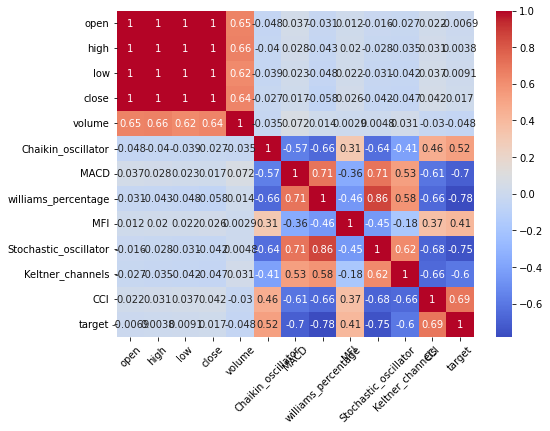

In [20]:
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax = ax)
plt.xticks(rotation = 45)
plt.show()

In [21]:
df

,timestamp,open,high,low,close,volume,Chaikin_oscillator,MACD,williams_percentage,MFI,Stochastic_oscillator,Keltner_channels,CCI,target
0,2018-01-01,13850.49,13921.53,12877.67,13444.88,1.057522e+09,0,0,0,0,0,0,0,0
1,2018-01-02,13444.88,15306.13,12934.16,14754.13,1.956783e+09,1,-1,0,0,0,0,0,0
2,2018-01-03,14754.09,15435.01,14579.71,15156.62,1.604207e+09,1,-1,0,0,0,0,0,0
3,2018-01-04,15156.49,15408.66,14244.67,15180.08,1.656715e+09,1,-1,-1,0,0,0,0,1
4,2018-01-05,15180.08,17126.95,14832.36,16954.78,2.283989e+09,1,-1,-1,0,-1,-1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,2023-03-31,28037.46,28650.47,27541.23,28477.29,1.436740e+09,1,-1,-1,-1,0,0,0,1
1916,2023-04-01,28477.29,28810.95,28265.42,28465.30,5.632994e+08,1,-1,0,1,0,0,1,0
1917,2023-04-02,28465.30,28538.36,27880.95,28186.76,5.925811e+08,-1,1,0,1,0,0,0,0
1918,2023-04-03,28186.76,28494.64,27290.26,27810.08,1.467725e+09,-1,1,1,-1,1,0,0,-1


In [22]:
df.to_csv('indicators_optimized.csv')